In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import RandomUnderSampler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings 
warnings.filterwarnings('ignore')
import time

In [2]:
# Load train and test data
train_df = pd.read_csv("../data/train_data.csv")
test_df = pd.read_csv("../data/test_data.csv")

In [5]:
# Assign `is_fraud` column as y
X_train = train_df.loc[:, train_df.columns != 'is_fraud']
y_train = train_df['is_fraud']

X_test = test_df.loc[:, test_df.columns != 'is_fraud']
y_test = test_df['is_fraud']

# Standardize numerical columns
scaler_train = StandardScaler()
numeric_cols_train = X_train.select_dtypes(include=['number'])
X_train[numeric_cols_train.columns] = scaler_train.fit_transform(numeric_cols_train)

scaler_test = StandardScaler()
numeric_cols_test = X_test.select_dtypes(include=['number'])
X_test[numeric_cols_test.columns] = scaler_test.fit_transform(numeric_cols_test)

#### Random UnderSampling

In [6]:
# Apply random undersampling to train dataset
rus = RandomUnderSampler(sampling_strategy=0.1, random_state=123)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
print(f'Size of X_train after random undersampling: {len(X_train_rus)}')

Size of X_train after random undersampling: 80256


#### Smote-NC

In [7]:
# Obtain indices for categorical variables
categorical_columns = X_train.select_dtypes(include=['object', 'category']).columns
categorical_columns_idx = [X_train.columns.get_loc(c) for c in categorical_columns]

# Apply SMOTE-NC on training data
sm = SMOTENC(categorical_features=categorical_columns_idx, random_state=123, sampling_strategy=0.5)
X_train_smote, y_train_smote = sm.fit_resample(X_train_rus, y_train_rus)

print(f'Train data size:{len(X_train_smote)}')
print(f'Fraud proportion in train data: {round(y_train_smote.mean(), 2)}')

Train data size:109440
Fraud proportion in train data: 0.33


### One-Hot Encoding

In [9]:
# Apply one-hot encoding on train and test data
X_train_ohe = pd.get_dummies(X_train_smote, drop_first = True)
X_test_ohe = pd.get_dummies(X_test, drop_first = True)
X_test_ohe = X_test_ohe.reindex(columns=X_train_ohe.columns, fill_value=0)

print(f'Number of columns after one-hot encoding: {len(X_train_ohe.columns)}')

Number of columns after one-hot encoding: 541


### Pipeline with Lasso

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END classifier__criterion=gini, classifier__max_depth=10, classifier__max_features=sqrt, classifier__n_estimators=100; total time=  55.6s
[CV] END classifier__criterion=gini, classifier__max_depth=10, classifier__max_features=sqrt, classifier__n_estimators=100; total time=  56.2s
[CV] END classifier__criterion=gini, classifier__max_depth=10, classifier__max_features=sqrt, classifier__n_estimators=100; total time=  56.5s
[CV] END classifier__criterion=gini, classifier__max_depth=10, classifier__max_features=sqrt, classifier__n_estimators=100; total time=  56.8s
[CV] END classifier__criterion=gini, classifier__max_depth=10, classifier__max_features=sqrt, classifier__n_estimators=100; total time=  57.0s
[CV] END classifier__criterion=gini, classifier__max_depth=10, classifier__max_features=sqrt, classifier__n_estimators=150; total time= 1.0min
[CV] END classifier__criterion=gini, classifier__max_depth=10, classifier__max_f

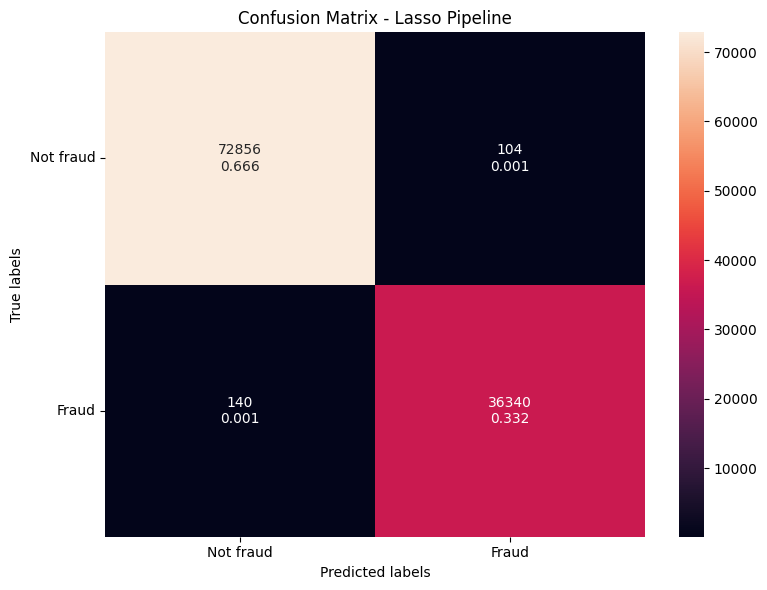

Chosen hyperparameters: {'classifier__criterion': 'entropy', 'classifier__max_depth': 15, 'classifier__max_features': 'sqrt', 'classifier__n_estimators': 150}

Top 10 most important features:
                     Feature  Importance
2           prev_trans_fraud    0.381784
7                visited_cat    0.283025
0                        amt    0.132076
4  merchant_prev_trans_fraud    0.095805
3          count_fraud_7days    0.038741
1                       hour    0.035300
6          hourly_risk_score    0.025735
5   merchant_acc_fraud_count    0.006326
8      first_second_purchase    0.001210


In [10]:

# Define the pipeline with Lasso for feature selection followed by RandomForest
lasso_pipe = Pipeline([
    ('feature_selection', SelectFromModel(Lasso(alpha=0.01))),
    ('classifier', RandomForestClassifier(random_state=123))
])

# Define parameter grid
param_grid = {
    'classifier__n_estimators': [100, 150],
    'classifier__max_features': ['sqrt', 'log2', 20],
    'classifier__max_depth': [10, 15],
    'classifier__criterion': ['gini', 'entropy']
}

# Set up GridSearchCV
cv_lasso_pipe = GridSearchCV(
    estimator=lasso_pipe,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring='f1'
)

# Fit the grid search
cv_lasso_pipe.fit(X_train_ohe, y_train_smote)

# Get the best model
best_lasso_pipe = cv_lasso_pipe.best_estimator_

# Evaluate using cross-validation
sk_folds_lasso = StratifiedKFold(5, shuffle=True, random_state=123)
y_pred_lasso_pipe = cross_val_predict(best_lasso_pipe, X_train_ohe, y_train_smote, cv=sk_folds_lasso)

# Calculate metrics
auc_lasso_pipe = roc_auc_score(y_train_smote, y_pred_lasso_pipe)
print("\nLasso Pipeline Results:")
print(f"accuracy: {accuracy_score(y_train_smote, y_pred_lasso_pipe)}, "
      f"precision: {precision_score(y_train_smote, y_pred_lasso_pipe, average='macro', zero_division=0.0)}, "
      f"recall: {recall_score(y_train_smote, y_pred_lasso_pipe, average='macro')}, "
      f"f1: {f1_score(y_train_smote, y_pred_lasso_pipe, average='macro', zero_division=0.0)}")
print(f'AUC: {round(auc_lasso_pipe, 2)}')

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm_lasso = confusion_matrix(y_train_smote, y_pred_lasso_pipe)

# Format text in boxes
group_counts = ["{0:g}".format(value) for value in cm_lasso.flatten()]
group_percentages = ["{0:.3f}".format(value) for value in cm_lasso.flatten()/np.sum(cm_lasso)]
values = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts, group_percentages)]
values = np.asarray(values).reshape(2, 2)

# Create plot for Lasso Pipeline
ax = plt.subplot()
sns.heatmap(cm_lasso, annot=values, fmt='')

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix - Lasso Pipeline')
ax.xaxis.set_ticklabels(['Not fraud', 'Fraud'])
ax.yaxis.set_ticklabels(['Not fraud', 'Fraud'], rotation=0)
plt.tight_layout()
plt.show()

# Report chosen hyperparameters
print(f'Chosen hyperparameters: {cv_lasso_pipe.best_params_}')

# Get feature importances from the best model
# First, identify which features were selected
selected_features_mask = best_lasso_pipe.named_steps['feature_selection'].get_support()
selected_features = X_train_ohe.columns[selected_features_mask]

# Get feature importances from the classifier
feature_importances = best_lasso_pipe.named_steps['classifier'].feature_importances_

# Create dataframe of importances
importance_df = pd.DataFrame({
    'Feature': selected_features,
    'Importance': feature_importances
})

print('\nTop 10 most important features:')
print(importance_df.sort_values(by='Importance', ascending=False)[:10])

### Pipeline with RFECV

In [ ]:

# Start timer
start_time = time.time()


class TwoStageRFECV(BaseEstimator, TransformerMixin):
    def __init__(self, estimator=None, step1=0.1, step2=5, cv=5, 
                 scoring='f1', min_features_to_select=5, n_jobs=-1, verbose=1):
        self.estimator = estimator
        self.step1 = step1  # First stage step (by 10%)
        self.step2 = step2  # Second stage step (by 5 features)
        self.cv = cv
        self.scoring = scoring
        self.min_features_to_select = min_features_to_select
        self.n_jobs = n_jobs
        self.verbose = verbose
        self.n_features_ = None
        self.support_ = None
        self.ranking_ = None
        self.grid_scores_ = None
        
    def fit(self, X, y):
        # First stage RFECV with coarse step (percentage-based)
        if self.verbose > 0:
            print("Starting first stage RFECV with step={}...".format(self.step1))
            
        stage1_rfecv = RFECV(
            estimator=self.estimator,
            step=self.step1,
            cv=self.cv,
            scoring=self.scoring,
            min_features_to_select=self.min_features_to_select,
            n_jobs=self.n_jobs,
            verbose=self.verbose
        )
        stage1_rfecv.fit(X, y)
        
        # Get features selected from first stage
        stage1_support = stage1_rfecv.support_
        X_reduced = X.loc[:, stage1_support]
        
        if self.verbose > 0:
            print(f"First stage complete. Reduced features from {X.shape[1]} to {X_reduced.shape[1]}")
            print("Starting second stage RFECV with step={}...".format(self.step2))
        
        # Second stage RFECV with fine-grained step (integer-based)
        stage2_rfecv = RFECV(
            estimator=self.estimator,
            step=self.step2,  # Remove specific number of features at each iteration
            cv=self.cv,
            scoring=self.scoring,
            min_features_to_select=self.min_features_to_select,
            n_jobs=self.n_jobs,
            verbose=self.verbose
        )
        stage2_rfecv.fit(X_reduced, y)
        
        # Map second stage results back to original feature space
        self.stage1_support_ = stage1_support
        self.stage2_support_ = stage2_rfecv.support_
        
        # Create the final support_ mask for the original feature space
        self.support_ = np.zeros(X.shape[1], dtype=bool)
        stage1_indices = np.where(stage1_support)[0]
        stage2_indices = np.where(stage2_rfecv.support_)[0]
        final_indices = stage1_indices[stage2_indices]
        self.support_[final_indices] = True
        
        # Store other attributes
        self.n_features_ = np.sum(self.support_)
        
        # Create ranking (combining both stages)
        self.ranking_ = np.ones(X.shape[1], dtype=int) * (X.shape[1] - stage1_indices.shape[0] + 1)
        selected_ranking = stage2_rfecv.ranking_
        for i, idx in enumerate(stage1_indices):
            self.ranking_[idx] = selected_ranking[i] if i < len(selected_ranking) else 1
        
        # Store grid scores from second stage
        self.grid_scores_ = stage2_rfecv.grid_scores_
        
        # Log completion
        if self.verbose > 0:
            print(f"Two-stage RFECV complete. Selected {self.n_features_} features out of {X.shape[1]}")
        
        return self
    
    def transform(self, X):
        # Apply feature selection mask to input data
        return X.loc[:, self.support_]
    
    def get_support(self, indices=False):
        """
        Get the support mask or indices of selected features.
        
        Parameters
        ----------
        indices : bool, default=False
            If True, returns the indices of the features that are selected.
            
        Returns
        -------
        support : array
            Boolean mask or indices of selected features.
        """
        if indices:
            return np.where(self.support_)[0]
        else:
            return self.support_



Fitting RFECV pipeline with GridSearchCV - this may take some time...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting estimator with 541 features.
Fitting estimator with 541 features.
Fitting estimator with 541 features.
Fitting estimator with 541 features.
Fitting estimator with 541 features.
Fitting estimator with 541 features.
Fitting estimator with 541 features.Fitting estimator with 541 features.

Fitting estimator with 541 features.
Fitting estimator with 541 features.
Fitting estimator with 541 features.
Fitting estimator with 541 features.
Fitting estimator with 541 features.
Fitting estimator with 541 features.
Fitting estimator with 541 features.
Fitting estimator with 541 features.
Fitting estimator with 541 features.
Fitting estimator with 541 features.
Fitting estimator with 541 features.
Fitting estimator with 541 features.
Fitting estimator with 541 features.
Fitting estimator with 541 features.
Fitting estimator with 541 features.
Fitting estimator

KeyboardInterrupt: 

In [ ]:
# Create the two-stage RFECV pipeline
two_stage_rfecv_pipe = Pipeline([
    ('feature_selection', TwoStageRFECV(
        estimator=RandomForestClassifier(n_estimators=100, random_state=123),
        step1=0.1,  # First stage: Remove 10% of features at each iteration
        step2=5,    # Second stage: Remove 5 features at each iteration
        cv=5,
        scoring='f1',
        min_features_to_select=5,
        n_jobs=-1,
        verbose=1
    )),
    ('classifier', RandomForestClassifier(random_state=123))
])

# Define parameter grid
param_grid = {
    'classifier__n_estimators': [100, 150],
    'classifier__max_features': ['sqrt', 'log2', 20],
    'classifier__max_depth': [10, 15],
    'classifier__criterion': ['gini', 'entropy']
}

# Set up GridSearchCV
cv_two_stage_rfecv = GridSearchCV(
    estimator=two_stage_rfecv_pipe,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring='f1'
)

# Fit the grid search (assuming X_train_ohe and y_train_smote are defined)
print("Fitting two-stage RFECV pipeline with GridSearchCV - this may take some time...")
cv_two_stage_rfecv.fit(X_train_ohe, y_train_smote)

# Get the best model
best_two_stage_pipe = cv_two_stage_rfecv.best_estimator_

# Evaluate using cross-validation
sk_folds = StratifiedKFold(5, shuffle=True, random_state=123)
y_pred_two_stage = cross_val_predict(best_two_stage_pipe, X_train_ohe, y_train_smote, cv=sk_folds)

# Calculate time elapsed
elapsed_time = time.time() - start_time
print(f"\nTotal execution time: {elapsed_time:.2f} seconds ({elapsed_time/60:.2f} minutes)")

In [ ]:
# Calculate metrics
auc_two_stage = roc_auc_score(y_train_smote, y_pred_two_stage)
print("\nTwo-Stage RFECV Pipeline Results:")
print(f"accuracy: {accuracy_score(y_train_smote, y_pred_two_stage)}, "
      f"precision: {precision_score(y_train_smote, y_pred_two_stage, average='macro', zero_division=0.0)}, "
      f"recall: {recall_score(y_train_smote, y_pred_two_stage, average='macro')}, "
      f"f1: {f1_score(y_train_smote, y_pred_two_stage, average='macro', zero_division=0.0)}")
print(f'AUC: {round(auc_two_stage, 2)}')

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_train_smote, y_pred_two_stage)

# Format text in boxes
group_counts = ["{0:g}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.3f}".format(value) for value in cm.flatten()/np.sum(cm)]
values = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts, group_percentages)]
values = np.asarray(values).reshape(2, 2)

# Create plot
ax = plt.subplot()
sns.heatmap(cm, annot=values, fmt='')

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix - Two-Stage RFECV Pipeline')
ax.xaxis.set_ticklabels(['Not fraud', 'Fraud'])
ax.yaxis.set_ticklabels(['Not fraud', 'Fraud'], rotation=0)
plt.tight_layout()
plt.show()

# Report chosen hyperparameters
print(f'Chosen hyperparameters: {cv_two_stage_rfecv.best_params_}')

# Get number of selected features
n_features = best_two_stage_pipe.named_steps['feature_selection'].n_features_

# Get selected features
selected_features_mask = best_two_stage_pipe.named_steps['feature_selection'].get_support()
selected_features = X_train_ohe.columns[selected_features_mask]
print(f"\nOptimal number of features selected by two-stage RFECV: {n_features}")
print("Selected features:", selected_features.tolist())



In [ ]:
# Get feature importances from the classifier
feature_importances = best_two_stage_pipe.named_steps['classifier'].feature_importances_

# Create dataframe of importances
importance_df = pd.DataFrame({
    'Feature': selected_features,
    'Importance': feature_importances
})

print('\nTop 10 most important features:')
print(importance_df.sort_values(by='Importance', ascending=False)[:10])

# Plot the number of features and cross-validation scores
plt.figure(figsize=(10, 6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (f1-score)")
plt.plot(
    range(1, len(best_two_stage_pipe.named_steps['feature_selection'].grid_scores_) + 1),
    best_two_stage_pipe.named_steps['feature_selection'].grid_scores_
)
plt.title("Two-Stage RFECV Feature Selection Score")
plt.tight_layout()
plt.show()